In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.preprocessing.image import  img_to_array, load_img
from skimage import io, color
from PIL import Image
from tqdm import tqdm

In [ ]:
sigma_center = 0.6
sigma_ring = 1.54

k_off = 1 # тормозящая область (знак активации отрицательный)
k_on = 2 # возбуждающая область (знак активации положительный)

In [ ]:
sigma_d = 0.8

G_d = 8 * np.exp(-(xx**2 + yy**2)/(2*sigma_d**2)) * (1 - (xx**2 + yy**2)/(2*sigma_d**2))

In [ ]:
X = np.linspace(-3, 3, 7)
Y = np.linspace(-3, 3, 7)

xx, yy = np.meshgrid(X, Y)

G_center_on = np.exp(-(xx**2 + yy**2)/(2*sigma_center**2)) * (-1)**k_on
G_ring_on = np.exp(-(xx**2 + yy**2)/(2*sigma_ring**2)) * (1 / math.sqrt(2 * np.pi)) * (-1)**k_on
G_center_off = np.exp(-(xx**2 + yy**2)/(2*sigma_center**2)) * (-1)**k_off
G_ring_off = np.exp(-(xx**2 + yy**2)/(2*sigma_ring**2)) * (1 / math.sqrt(2 * np.pi)) * (-1)**k_off

In [ ]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy, startx:startx+cropx]

def zero_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    center = np.zeros(img.shape)
    center[starty:starty+cropy, startx:startx+cropx] = img[starty:starty+cropy, startx:startx+cropx]
    return img - center

In [ ]:
f1 = crop_center(G_center_on, 3, 3)
f2 = G_ring_off
f3 = crop_center(G_center_off, 3, 3)
f4 = G_ring_on

In [ ]:
def extract_A(img):
    image_in_lab1 = color.rgb2lab(img/255.0)
    a_channel = np.zeros(img.shape)
    a_channel[:,:,0]=60
    a_channel = image_in_lab1[:,:,1]
    return a_channel

def extract_B(img):
    image_in_lab1 = color.rgb2lab(img/255.0)
    b_channel = np.zeros(img.shape)
    b_channel[:,:,0]=60
    b_channel = image_in_lab1[:,:,2]
    return b_channel

def extract_L(img):
    image_in_lab1 = color.rgb2lab(img/255.0)
    l_channel = np.zeros(img.shape)
    l_channel = image_in_lab1[:,:,0]
    return l_channel

In [ ]:
def convolve(image, kernel, strides):
    # Cross Correlation
    # kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Iterate through image
    for y in tqdm(range(image.shape[1])):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * image[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

In [ ]:
def convolve_channel(img_path, channel):
    img = img_to_array(load_img(img_path))

    if channel == 'a':
        axis = 1
        extracted_channel = extract_A(img)
    elif channel == 'b':
        axis = 2
        extracted_channel = extract_B(img)
    else:
        return
    
    activation_map = convolve(extracted_channel, G_center_on - G_ring_off, 1)
    # res = np.zeros((activation_map.shape[0],activation_map.shape[1], 3))
    # res[:,:,0]=50
    # res[:,:,axis] = activation_map
    # resulting_map = color.lab2rgb(res)

    return activation_map

In [ ]:
def convolve_channel_double(img_path, channel):
    img = img_to_array(load_img(img_path))

    if channel == 'a':
        axis = 1
        extracted_channel = extract_A(img)
    elif channel == 'b':
        axis = 2
        extracted_channel = extract_B(img)
    else:
        return
    
    activation_map = convolve(extracted_channel, G_d, 1)
    # res = np.zeros((activation_map.shape[0],activation_map.shape[1], 3))
    # res[:,:,0]=50
    # res[:,:,axis] = activation_map
    # resulting_map = color.lab2rgb(res)

    return activation_map

In [ ]:
img_path = "/content/ryoji-iwata-n31JPLu8_Pw-unsplash.jpg"
img = img_to_array(load_img(img_path))

a_map = convolve_channel(img_path, 'a')
b_map = convolve_channel(img_path, 'b')


100%|█████████▉| 1703/1709 [00:21<00:00, 79.85it/s]


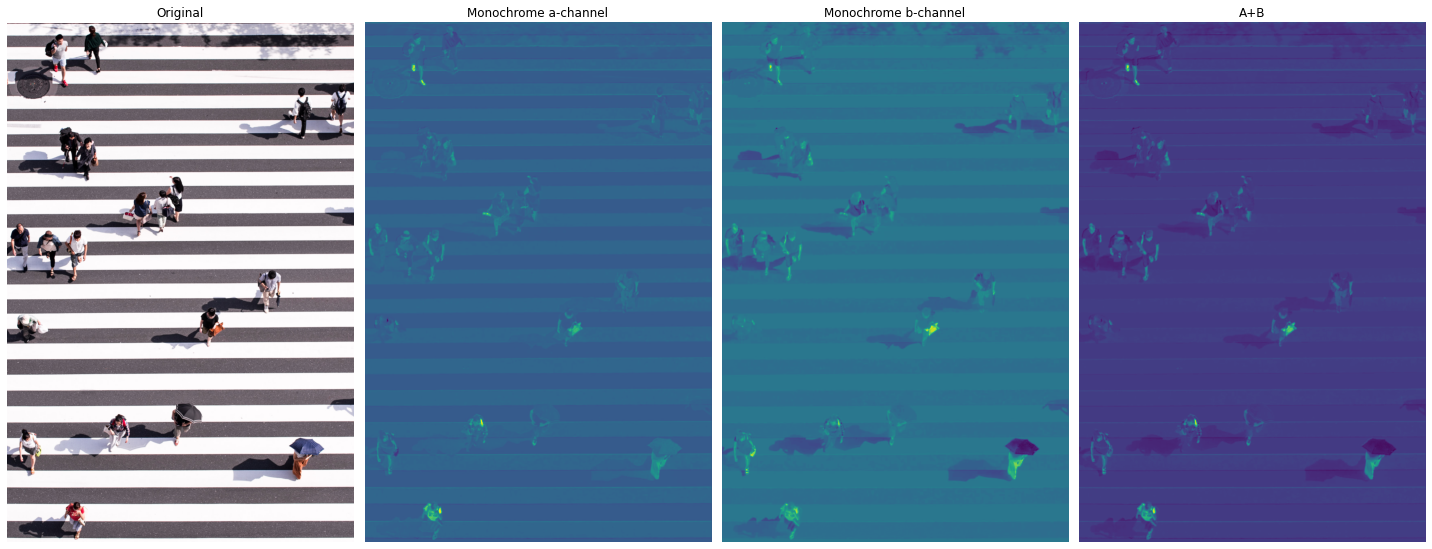

In [ ]:
# Plot the results
fig, axes = plt.subplots(ncols=4, figsize=(20, 20))
data = [('Original', img/255.0), ('Monochrome a-channel', a_map), ('Monochrome b-channel', b_map), ('A+B', a_map + b_map)]

for ax, (title, img) in zip(axes, data):
    ax.set_title(title)
    ax.imshow(img)
    ax.axis('off')

fig.tight_layout()
plt.show()

In [ ]:
activation_a_double = convolve_channel_double(img_path, 'a')
activation_b_double = convolve_channel_double(img_path, 'b')

100%|█████████▉| 1703/1709 [00:21<00:00, 78.39it/s]


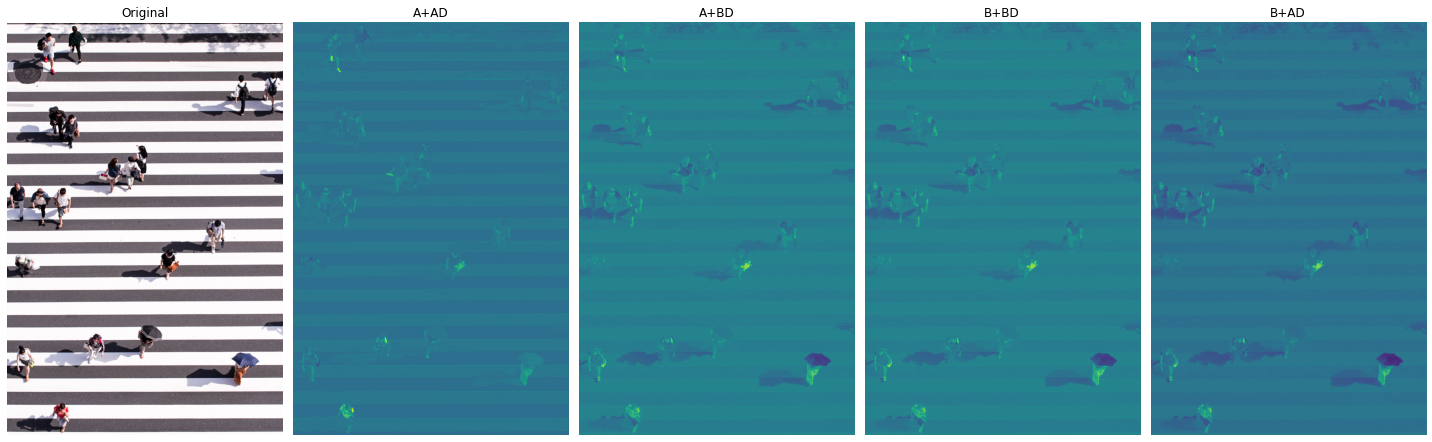

In [ ]:
img = img_to_array(load_img(img_path))

# Plot the results
fig, axes = plt.subplots(ncols=5, figsize=(20, 20))
data = [('Original', img/255.0), ('A+AD', a_map + activation_a_double), ('A+BD', b_map + activation_b_double), ('B+BD', activation_b_double + b_map), ('B+AD', activation_a_double + b_map)]

for ax, (title, img) in zip(axes, data):
    ax.set_title(title)
    ax.imshow(img)
    ax.axis('off')

fig.tight_layout()
plt.show()